# Find nights with Auxtel Spectra in OGA butler

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-02-18
- last update : 2024-05-03
- affiliation : IJCLab/IN2P3/CNRS



- Work with w_2024_16

The goal is to check the number of data available, their date.

## Check environnement
- Need ``setup lsst_sitcom`` in .users_setup 

In [1]:
from lsst.summit.utils.utils import checkStackSetup
checkStackSetup()

You are running w_2024_16 of lsst_distrib

Locally setup packages:
-----------------------
analysis_tools at /home/d/dagoret/repos/repos_w_2024_16/analysis_tools
atmospec       at /home/d/dagoret/repos/repos_w_2024_16/atmospec
spectractor    at /home/d/dagoret/repos/repos_w_2024_16/Spectractor


## Imports

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time

In [3]:
import matplotlib.ticker
%matplotlib inline

In [4]:
import spectractor
from spectractor.simulation.throughput import load_transmission,plot_transmission_simple,TelescopeTransmission
from spectractor import parameters
from spectractor.extractor import dispersers
from spectractor.config import load_config,set_logger
import os,sys

In [5]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [6]:
import lsst.daf.butler as dafButler

repo = "/repo/main"
repo = "/repo/embargo"
# repo = "LATISS"
butler = dafButler.Butler(repo)
registry = butler.registry

for c in sorted(registry.queryCollections()):
#    if "u/jneveu" in c and "auxtel_atmo" in c:
#        print(c)
    #if "u/dagoret" in c:
    if "u/dagoret" in c and "auxtel_atmo" in c:
        print(c)

u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208/20231220T142452Z
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221/20231221T125249Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208/20231208T215202Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208/20231208T211104Z
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240201
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240201/20240201T144534Z
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N149.5
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N149.5/20240215T190316Z
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N150
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N150/2024

## Config

### Config collection

In [9]:
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208"
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208"

# all spectra from September 2022 to december 2023
#the reconstruction done by  LambdaMin = 350.0 and spectractor v3.0.3 in 2023/12/21
#my_collection = "u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221"


# work done 5th Feb 2024
#my_collection = "u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsPTC_rebin2_240201"


#work done 19th Feb 2024
#my_collection = "u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsPTC_rebin2_240218_N150"
#my_collection = "u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N150"
#my_collection = "u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsPTC_rebin2_240222_N149.85"

# March 18 2024 
# Until the end of March
#my_collection = "u/jneveu/auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_testWithMaskedEdges_newBoundaries_newPolysRescaled_newFitBounds_adjustA1_lockedOrder2_removeThroughputTails/20240313T174059Z"



# May 3rd 2024
# Note the version of spectractor is v3.1.0, not 3.1.3
my_collection = "u/dagoret/auxtel_atmo_202401_v3.1.3_doNoGainsPTC_rebin2_240503"

### Config Auxtel

In [10]:
#config_path = "~/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
#config_path = "/home/d/dagoret/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
#config_fullpath = os.path.join(spectractor.__path__[0],"../config/auxtel.ini")
throughput_filename="multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt"

In [11]:
#load_config(config_fullpath)

## Check the presence of the spectra

### select the date of observation

### Fitted param file output name

- Note each date is overwritted inside the hdf5 file

In [12]:
#fitted_paramfile = f"fitted_atmparamfile_{DATEOBS}.hdf5"
fitted_paramfile = "fitted_atmparamfile_jan23-april2024.hdf5"

## Access to spectra using the butler

In [13]:
#where = f"instrument='LATISS' and visit.day_obs={DATEOBS}" 
where = "instrument='LATISS' "
records = list(butler.registry.queryDimensionRecords('visit', datasets='spectractorSpectrum', where=where,  collections=my_collection))
# records = list(butler.registry.queryDimensionRecords('visit', datasets='raw', where=where))

In [14]:
print(">>> Number of records : ",len(records))
records[-1]

>>> Number of records :  3254


visit.RecordClass(instrument='LATISS', id=2024042400354, day_obs=20240424, physical_filter='empty~holo4_003', name='AT_O_20240424_000354', seq_num=354, exposure_time=60.0, target_name='HD185975', observation_reason='object', science_program='spec-survey', azimuth=178.56229295232072, zenith_angle=62.026274709068275, region=ConvexPolygon([UnitVector3d(0.025894812481955767, -0.03389417340584398, -0.9990899077138448), UnitVector3d(0.027842231706454477, -0.03473096761215813, -0.9990087937662647), UnitVector3d(0.027016600297474255, -0.0366479670427638, -0.9989629772018576), UnitVector3d(0.025069181103370954, -0.03581117273214048, -0.9990440911523151)]), timespan=Timespan(begin=astropy.time.Time('2024-04-25 01:04:02.577991', scale='tai', format='iso'), end=astropy.time.Time('2024-04-25 01:05:02.815000', scale='tai', format='iso')))

### List first of first records

       visit:
          instrument
          id
          physical_filter
          name: 'AT_O_20231220_000354'
         day_obs
         seq_num
         exposure_time
         target_name
         observation_reason
         science_program: 
         azimuth
         zenith_angle
         timespan

In [15]:
df_spec = pd.DataFrame(columns=['id',
                                'name',
                                'day_obs', 
                                'seq_num',
                                'time_start',
                                'time_end', 
                                'target',
                                'filter',
                                'exposure_time',
                                'azimuth',
                                'zenith',
                                'obs_reason',
                                'science_program',
                                'jd',
                                'mjd'])

In [16]:
for count, info in enumerate(registry.queryDimensionRecords('visit', datasets='spectractorSpectrum', where=where,  collections=my_collection)):
       
    try:
        df_spec.loc[count] = [info.id, info.name, info.day_obs, info.seq_num,pd.to_datetime(info.timespan.begin.to_string()),pd.to_datetime(info.timespan.end.to_string()) ,
                                  info.target_name, info.physical_filter, info.exposure_time, info.azimuth,info.zenith_angle, info.observation_reason, info.science_program,
                                  info.timespan.begin.jd,info.timespan.begin.mjd ]
    except:
        print(">>>   Unexpected error:", sys.exc_info()[0])
        info_timespan_begin_to_string = "2021-01-01 00:00:00.00"
        info_timespan_end_to_string = "2051-01-01 00:00:00.00"
        info_timespan_begin_jd = 0
        info_timespan_begin_mjd = 0
        df_spec.loc[count] = [info.id, info.name, info.day_obs, info.seq_num,
                                  pd.to_datetime(info_timespan_begin_to_string),
                                  pd.to_datetime(info_timespan_end_to_string) ,
                                  info.target_name, 
                                  info.physical_filter, info.exposure_time,info.azimuth,info.zenith_angle,
                                  info.zenith_angle,  info.observation_reason, info.science_program, info_timespan_begin_jd, info_timespan_begin_mjd  ]
 

In [17]:
df_spec

,id,name,day_obs,seq_num,time_start,time_end,target,filter,exposure_time,azimuth,zenith,obs_reason,science_program,jd,mjd
0,2023011700238,AT_O_20230117_000238,20230117,238,2023-01-18 02:34:06.207985,2023-01-18 02:34:36.433,HD185975,empty~holo4_003,30.0,181.962597,61.573525,object,spec,2.459963e+06,59962.107016
1,2023011700239,AT_O_20230117_000239,20230117,239,2023-01-18 02:34:49.018013,2023-01-18 02:35:19.259,HD185975,empty~holo4_003,30.0,181.955808,61.578990,object,spec,2.459963e+06,59962.107512
2,2023011700244,AT_O_20230117_000244,20230117,244,2023-01-18 02:45:03.252017,2023-01-18 02:45:33.484,HD074000,empty~holo4_003,30.0,80.361948,41.404231,object,spec,2.459963e+06,59962.114621
3,2023011700248,AT_O_20230117_000248,20230117,248,2023-01-18 03:05:35.183014,2023-01-18 03:06:05.422,HD185975,empty~holo4_003,30.0,181.650062,61.802681,object,spec,2.459963e+06,59962.128879
4,2023011700249,AT_O_20230117_000249,20230117,249,2023-01-18 03:06:18.106982,2023-01-18 03:06:48.337,HD185975,empty~holo4_003,30.0,181.642505,61.807304,object,spec,2.459963e+06,59962.129376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3249,2024042400332,AT_O_20240424_000332,20240424,332,2024-04-25 00:39:08.192011,2024-04-25 00:39:38.435,HD38666,empty~holo4_003,30.0,249.600156,55.236310,object,spec-survey,2.460426e+06,60425.027178
3250,2024042400333,AT_O_20240424_000333,20240424,333,2024-04-25 00:39:51.316018,2024-04-25 00:40:21.550,HD38666,empty~holo4_003,30.0,249.547138,55.381767,object,spec-survey,2.460426e+06,60425.027677
3251,2024042400347,AT_O_20240424_000347,20240424,347,2024-04-25 00:56:28.346015,2024-04-25 00:56:58.572,HD38666,empty~holo4_003,30.0,248.286872,58.736748,object,spec-survey,2.460426e+06,60425.039217
3252,2024042400353,AT_O_20240424_000353,20240424,353,2024-04-25 01:02:49.551994,2024-04-25 01:03:49.793,HD185975,empty~holo4_003,60.0,178.576209,62.032906,object,spec-survey,2.460426e+06,60425.043629


In [18]:
df_spec["year"] = df_spec["day_obs"].apply(lambda x : x//10_000)
df_spec["yearmonth"] = df_spec["day_obs"].apply(lambda x : x//100)
df_spec["time"] = pd.to_datetime(df_spec['time_start'])

In [19]:
df_spec["day_obs"].unique()

array([20230117, 20230118, 20230119, 20230131, 20230201, 20230202,
       20230214, 20230215, 20230216, 20230228, 20230301, 20230302,
       20230314, 20230315, 20230316, 20230509, 20230510, 20230511,
       20230523, 20230524, 20230525, 20230718, 20230720, 20230801,
       20230802, 20230815, 20230817, 20230829, 20230912, 20230913,
       20230914, 20230926, 20230927, 20230928, 20231010, 20231107,
       20231108, 20231113, 20231114, 20231115, 20231116, 20231120,
       20231127, 20231128, 20231129, 20231130, 20231204, 20231205,
       20231206, 20231207, 20231211, 20231212, 20231214, 20231215,
       20231219, 20231220, 20231221, 20231222, 20240129, 20240130,
       20240205, 20240206, 20240207, 20240212, 20240213, 20240214,
       20240215, 20240219, 20240220, 20240223, 20240226, 20240227,
       20240228, 20240229, 20240301, 20240303, 20240304, 20240305,
       20240306, 20240307, 20240308, 20240311, 20240312, 20240313,
       20240314, 20240319, 20240321, 20240325, 20240326, 20240

### Time series

In [20]:
df_spec_visit = df_spec.groupby(['day_obs']).count()["id"]
df_spec_visit.name = "countVisitperBandperNight" 
df_spec_visit

day_obs
20230117    129
20230118    128
20230119     65
20230131    202
20230201    118
           ... 
20240418      8
20240419      8
20240422     13
20240423      9
20240424     11
Name: countVisitperBandperNight, Length: 107, dtype: int64

Text(0.5, 1.0, 'Auxtel Spectro Year 2024 nspec = 3254 ndays = 107 (/repo/embargo)')

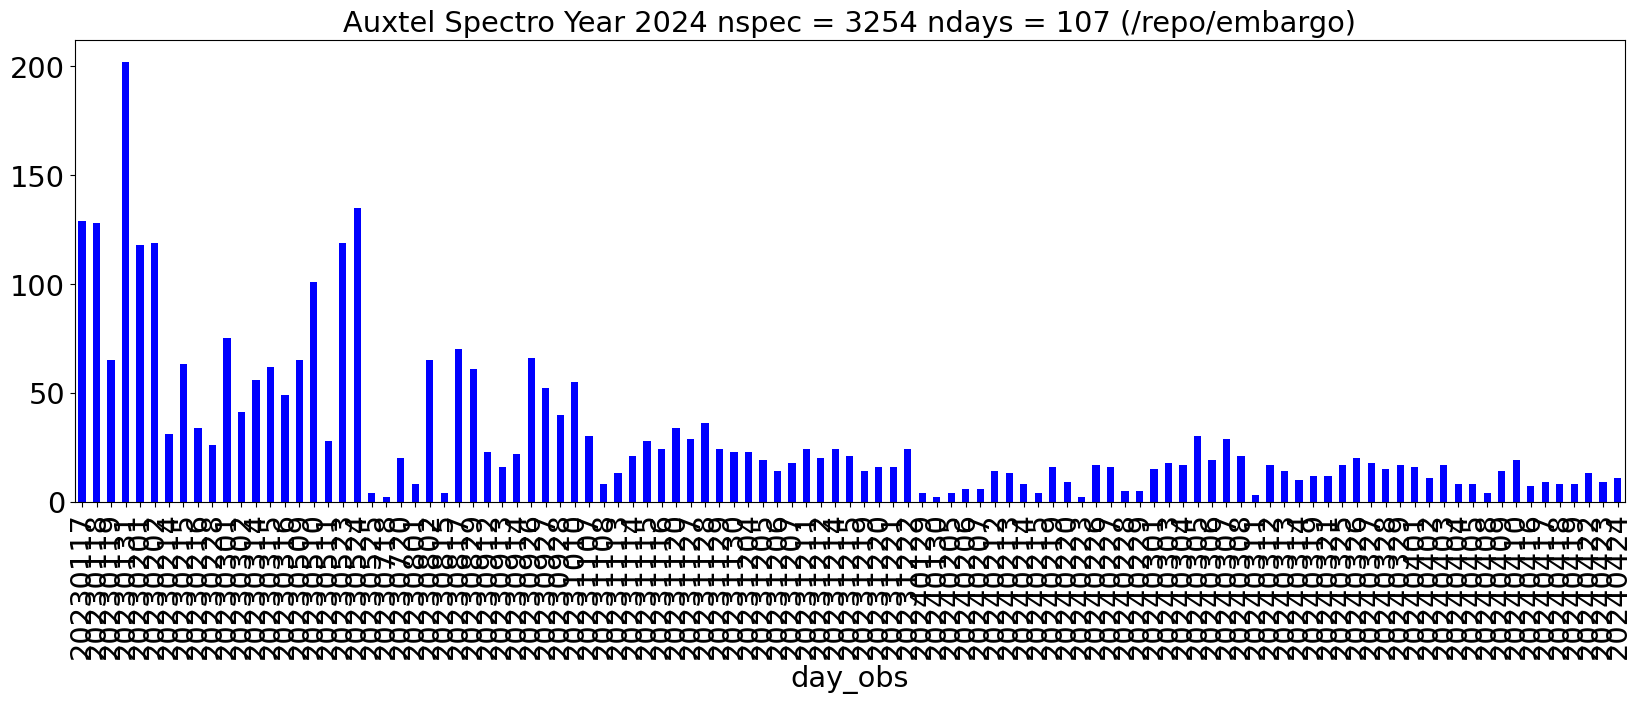

In [21]:
nspec = df_spec_visit.sum()
ndays = df_spec_visit.count()
suptitle = f"Auxtel Spectro Year 2024 nspec = {nspec} ndays = {ndays} (/repo/embargo)"
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_spec_visit.plot(x='day_obs',kind="bar",facecolor="b",ax=ax)
ax.set_title(suptitle)

Text(0.5, 0, 'year,month,day')

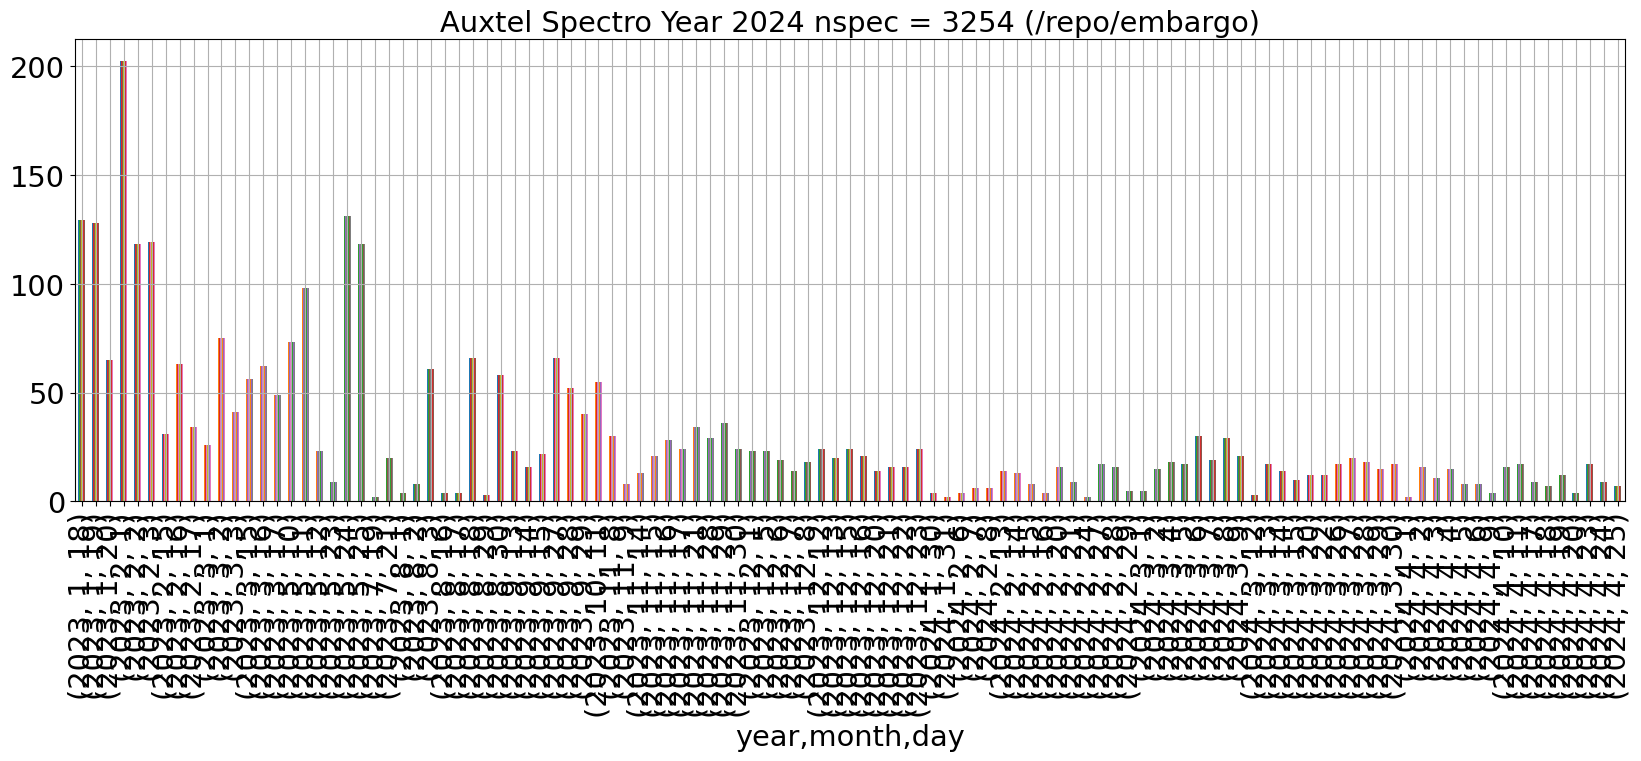

In [22]:
nspec = df_spec.id.count()
suptitle = f"Auxtel Spectro Year 2024 nspec = {nspec} (/repo/embargo)"
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_spec.groupby([df_spec["time"].dt.year, df_spec["time"].dt.month,df_spec["time"].dt.day]).count().plot(kind="bar",ax=ax,legend=False,grid=True)
ax.set_title(suptitle)
ax.set_xlabel("year,month,day")

## Save the series

In [23]:
df_spec_visit.to_csv("spec_series_repo_embargo_jan23-april24.csv")

In [24]:
df_2024 = df_spec[df_spec.year == 2024]

### Year 2024

In [25]:
df_2024["day_obs"].unique()

array([20240129, 20240130, 20240205, 20240206, 20240207, 20240212,
       20240213, 20240214, 20240215, 20240219, 20240220, 20240223,
       20240226, 20240227, 20240228, 20240229, 20240301, 20240303,
       20240304, 20240305, 20240306, 20240307, 20240308, 20240311,
       20240312, 20240313, 20240314, 20240319, 20240321, 20240325,
       20240326, 20240327, 20240328, 20240329, 20240401, 20240402,
       20240403, 20240404, 20240405, 20240408, 20240409, 20240410,
       20240416, 20240417, 20240418, 20240419, 20240422, 20240423,
       20240424])

In [26]:
df_spec["filter"].unique()

array(['empty~holo4_003', 'OG550_65mm_1~holo4_003'], dtype=object)

In [27]:
df_spec.target.unique()

array(['HD185975', 'HD074000', 'MU-COL', 'HD111980', 'HD37962',
       'HD031128', 'HD38949', 'ETA1-DOR', 'HD60753', 'HD14943',
       'HD115169', 'HD 38949', 'HD 38666', 'HD 42525', 'HD38666',
       'HD42525', 'HD142331', 'HD146233', 'HD167060', 'HD200654',
       'Feige110', 'HD009051', 'HD2811', 'HD205905', 'HD160617'],
      dtype=object)

In [28]:
df_spec.science_program.unique()

array(['spec', 'SITCOM-621', 'SITCOM-1001', 'BLOCK-102', 'spec-survey'],
      dtype=object)

In [29]:
df_spec.obs_reason.unique()

array(['object', 'generic', 'sitcom-1043', 'y_offset_-100'], dtype=object)

## Plot Year 2024

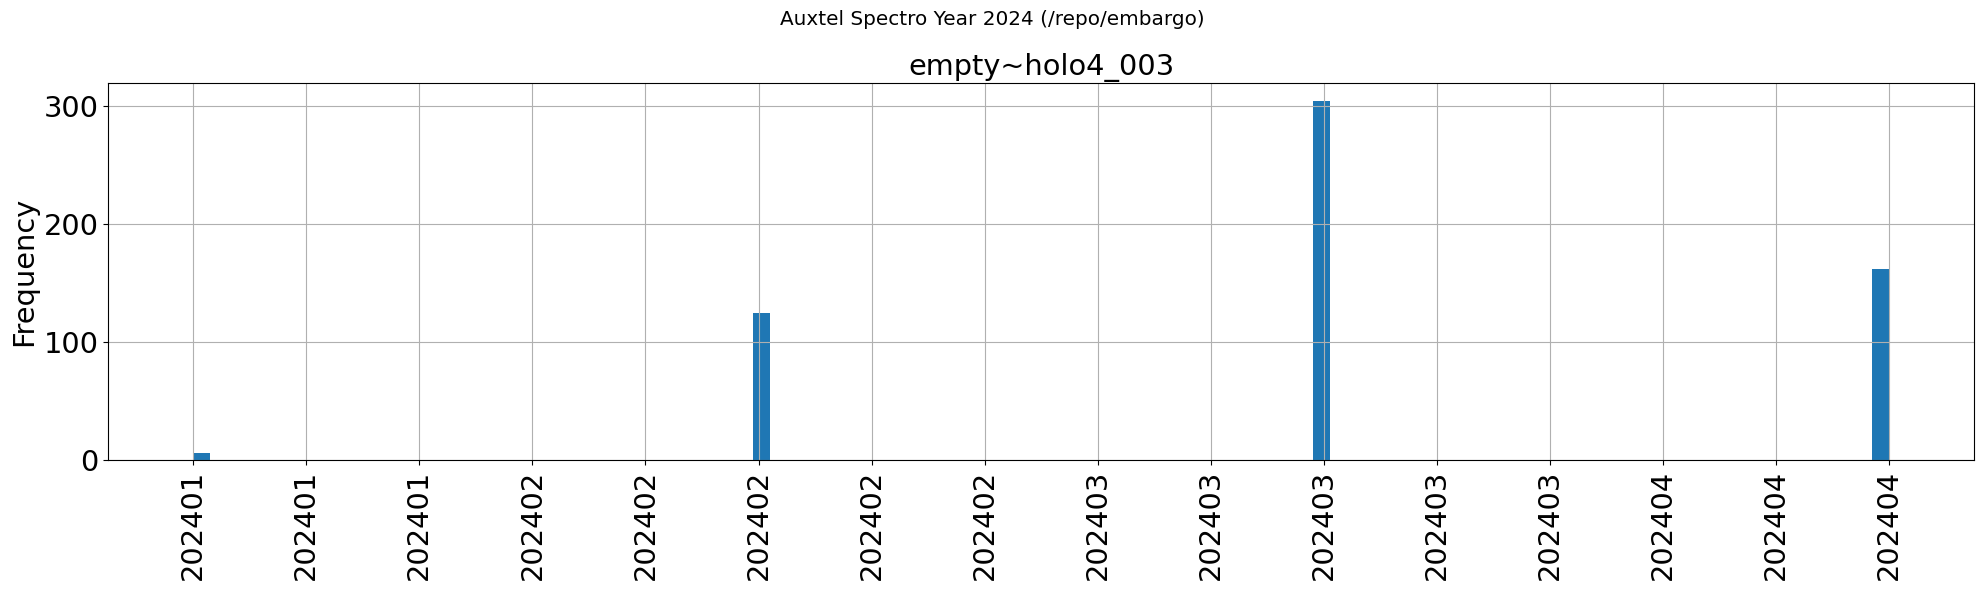

In [30]:
suptitle = "Auxtel Spectro Year 2024 (/repo/embargo)"
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_2024.plot.hist(column=["yearmonth"] ,by="filter",bins=100,grid=True,ax=ax,legend=False)


# plot x axis as an int
locator = matplotlib.ticker.MultipleLocator(1)

plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)

plt.suptitle(suptitle)
plt.tight_layout()

In [31]:
df_2024.id.count()

597

Text(0.5, 0, 'year,month,day')

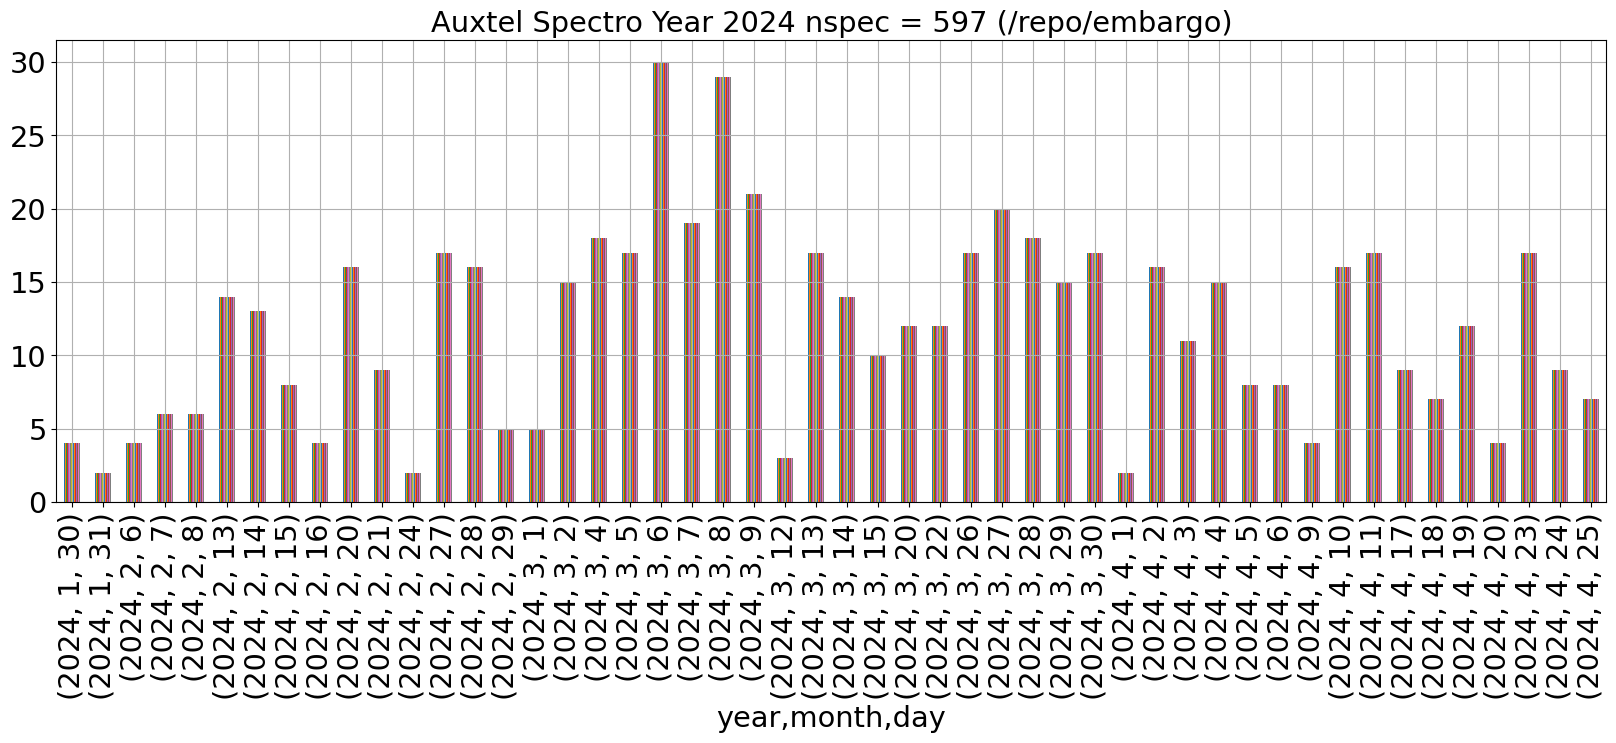

In [32]:
nspec = df_2024.id.count()
suptitle = f"Auxtel Spectro Year 2024 nspec = {nspec} (/repo/embargo)"
fig,ax = plt.subplots(1,1,figsize=(20,6))
df_2024.groupby([df_2024["time"].dt.year, df_2024["time"].dt.month,df_2024["time"].dt.day]).count().plot(kind="bar",ax=ax,legend=False,grid=True)
ax.set_title(suptitle)
ax.set_xlabel("year,month,day")

### Plot Year 2024

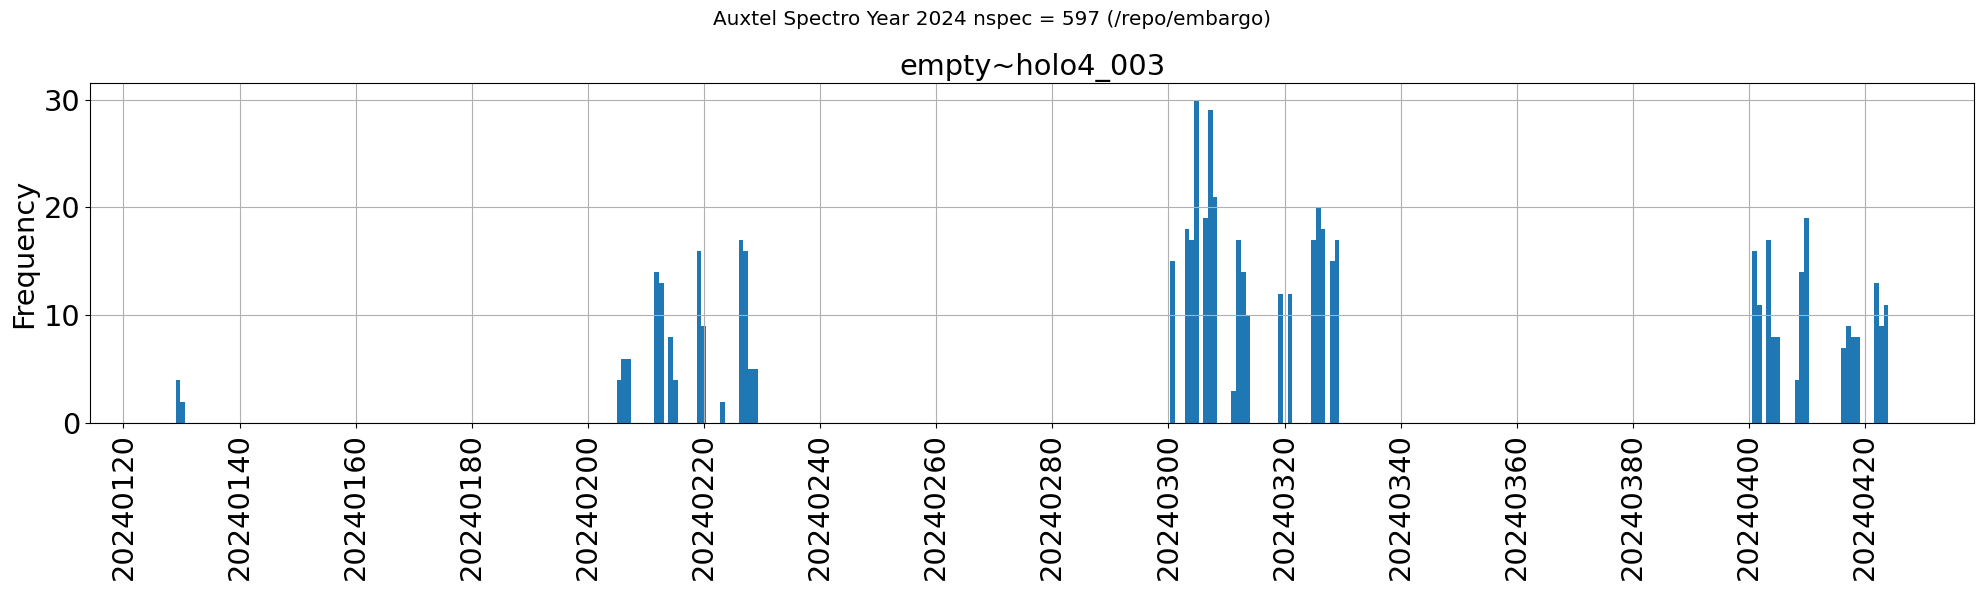

In [33]:
nspec = df_2024.id.count()
suptitle = f"Auxtel Spectro Year 2024 nspec = {nspec} (/repo/embargo)"

fig,ax = plt.subplots(1,1,figsize=(20,6))
df_2024.plot.hist(column=["day_obs"] ,by="filter",bins=365,grid=True,ax=ax,legend=False)


# plot x axis as an int
locator = matplotlib.ticker.MultipleLocator(1)

plt.gca().xaxis.set_major_locator(locator)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=90)

plt.suptitle(suptitle)
plt.tight_layout()

Text(0.5, 0, 'year,month,day')

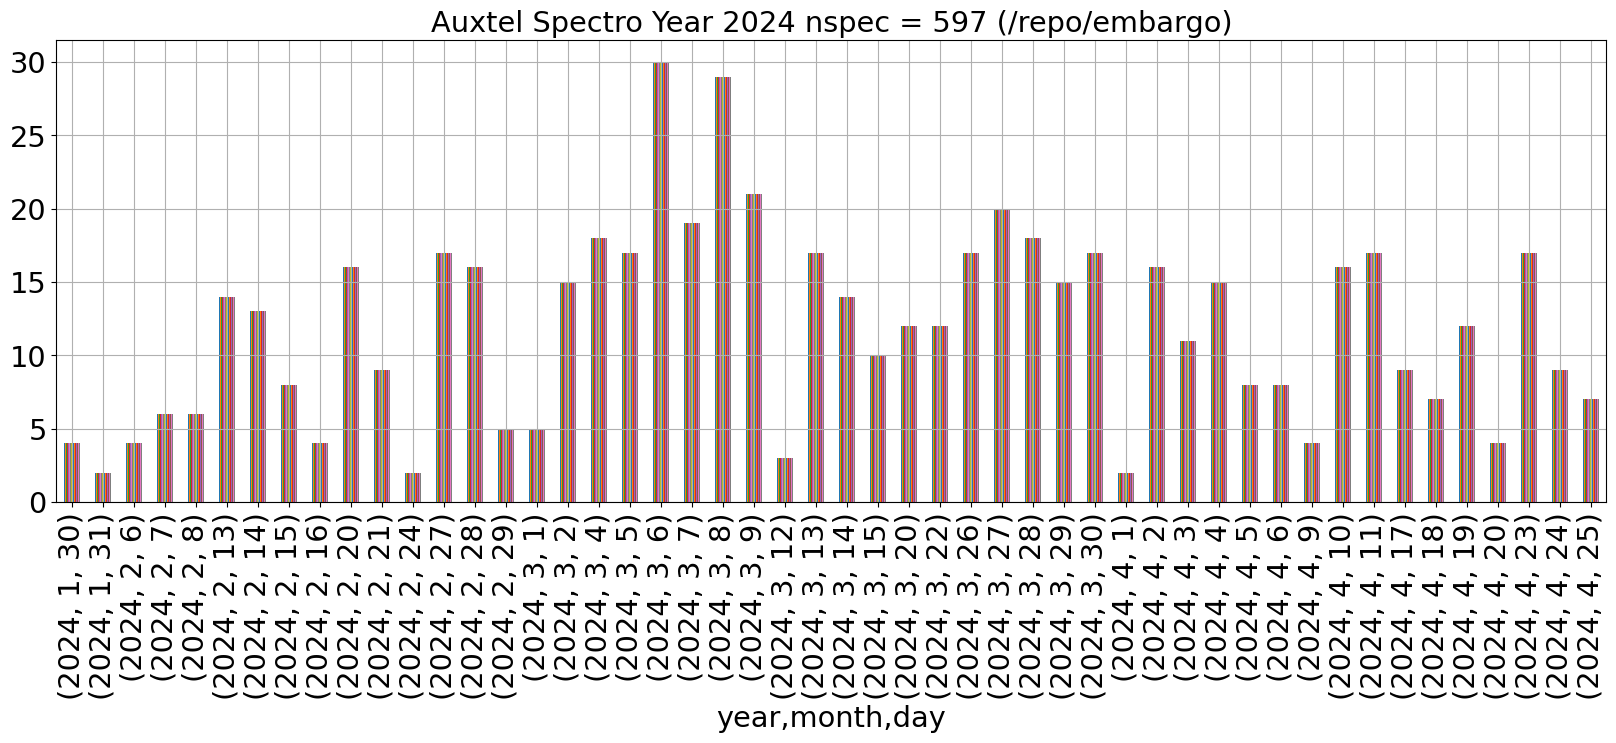

In [35]:
nspec = df_2024.id.count()
suptitle = f"Auxtel Spectro Year 2024 nspec = {nspec} (/repo/embargo)"

fig,ax = plt.subplots(1,1,figsize=(20,6))
df_2024.groupby([df_2024["time"].dt.year, df_2024["time"].dt.month,df_2024["time"].dt.day]).count().plot(kind="bar",ax=ax,legend=False,grid=True)
ax.set_title(suptitle)
ax.set_xlabel("year,month,day")

# Visits

In [36]:
df_spec_visit.cumsum()

day_obs
20230117     129
20230118     257
20230119     322
20230131     524
20230201     642
            ... 
20240418    3213
20240419    3221
20240422    3234
20240423    3243
20240424    3254
Name: countVisitperBandperNight, Length: 107, dtype: int64

In [37]:
def convertNumToDatestr(num):
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)

In [38]:
dt = [ convertNumToDatestr(num) for num in df_spec_visit.index ]

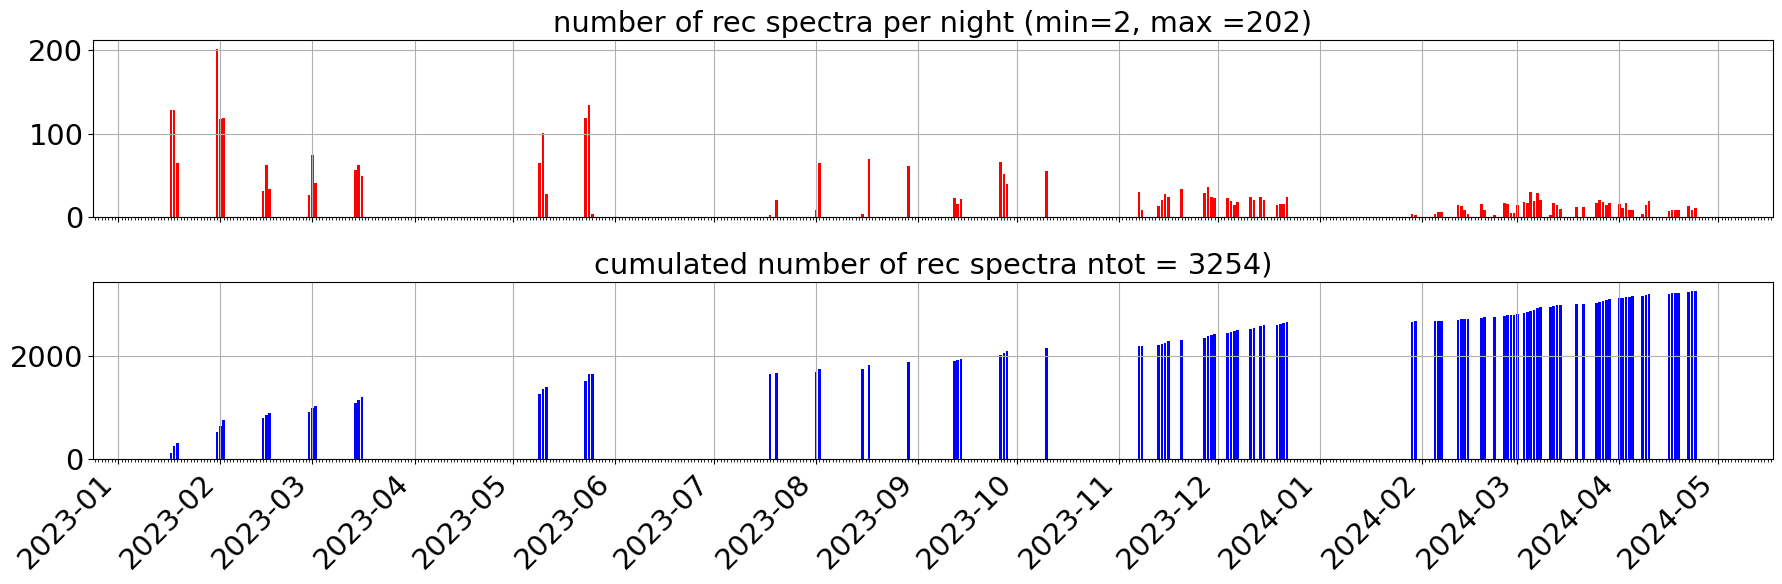

In [39]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(18, 6),sharex=True)


# fit 1
#ax.plot(dt,df_spec_visit.values,marker='o', markersize=15,lw=0)
ax1.bar(dt,df_spec_visit.values,lw=5,facecolor='r')
ax1.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax1.xaxis.set_minor_locator(day_locator)
ax1.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()

minnspec= df_spec_visit.min()
maxnspec= df_spec_visit.max()
totnspec= df_spec_visit.sum()
title1 = f"number of rec spectra per night (min={minnspec}, max ={maxnspec})"
ax1.set_title(title1)

#fig.autofmt_xdate() # rotation
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=45, ha='right')

ax2.bar(dt,df_spec_visit.cumsum().values,lw=5,facecolor='b')
ax2.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax2.xaxis.set_minor_locator(day_locator)
ax2.xaxis.set_major_formatter(year_month_formatter)
ax2.grid()

#fig.autofmt_xdate() # rotation
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')
title2 = f"cumulated number of rec spectra ntot = {totnspec})"
ax2.set_title(title2)

plt.tight_layout()